# How to run this notebook

In order to run this notebook using Poetry, you first need to create a kernel that uses the virtualenv that you use for SeaGOAT development.

In order to do that, you can run the following commands:

```bash
poetry run python -m ipykernel install --user --name seagoat-poetry
```

In [700]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [701]:
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.getipython import get_ipython
from IPython.display import Javascript
import pandas as pd

In [702]:
from load_results import load_results
from load_results import load_results_for_all_runs
from load_results import get_percentage_of_queries_with_correct_results

list_of_test_runs = get_list_of_test_runs()
list_of_test_runs

['gt -C1', 'gt -C2', 'initial test']

In [703]:
examples = load_results(list_of_test_runs[0])

## Quality of example cases

(array([ 9.,  0.,  0.,  0.,  0.,  2.,  3.,  4.,  1.,  0.,  0.,  0.,  3.,
        12., 21., 13.,  3.,  2.,  2.,  5.,  9., 28., 16.,  7.,  1.]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ,
        41.8, 45.6, 49.4, 53.2, 57. , 60.8, 64.6, 68.4, 72.2, 76. , 79.8,
        83.6, 87.4, 91.2, 95. ]),
 <BarContainer object of 25 artists>)

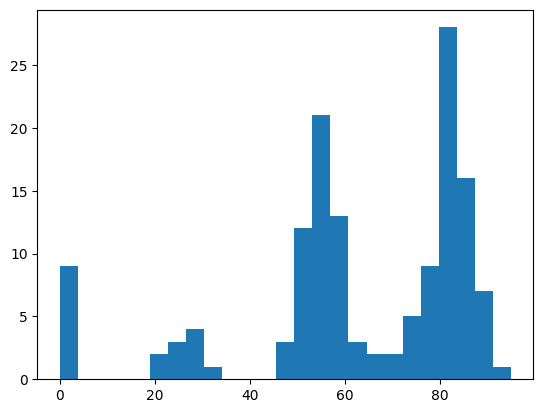

In [704]:
plt.hist([x['qualityScore'] for x in examples], 25)

### Total number of examples

In [705]:
len(examples)

141

### Number of examples after quality cutoff

In [706]:
MINIMUM_EXAMPLE_QUALITY = 75
examples = [example for example in examples if example['qualityScore'] >= MINIMUM_EXAMPLE_QUALITY]
len(examples)

62

(array([ 4.,  5.,  8., 10., 12., 15.,  3.,  2.,  2.,  1.]),
 array([75., 77., 79., 81., 83., 85., 87., 89., 91., 93., 95.]),
 <BarContainer object of 10 artists>)

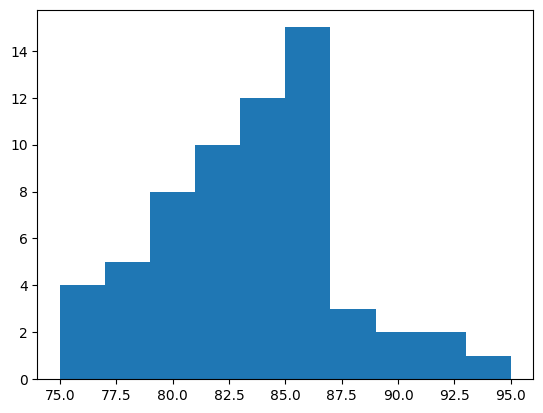

In [707]:
plt.hist([x['qualityScore'] for x in examples], 10)

## List of test runs

In [708]:
all_results = load_results_for_all_runs(MINIMUM_EXAMPLE_QUALITY)
df = pd.DataFrame(all_results, columns=["Test run name", "Data", "Engine"])
df.drop(columns=["Data"])

,Test run name,Engine
0,random,random
1,gt -C1,seagoat
2,gt -C2,seagoat
3,initial test,seagoat


## Comparison of accuracy between test runs

In [709]:
df['Examples'] = df.apply(lambda row: len(row['Data']), axis=1)
df['Query success %'] = df.apply(get_percentage_of_queries_with_correct_results, axis=1).apply(lambda x: "{:.2%}".format(x))
df['Workflow success %'] = df.apply(get_percentage_of_examples_with_correct_results, axis=1).apply(lambda x: "{:.2%}".format(x))


df.drop(columns=["Data"])

,Test run name,Engine,Examples,Query success %,Workflow success %
0,random,random,62,0.46%,3.23%
1,gt -C1,seagoat,62,47.11%,85.48%
2,gt -C2,seagoat,62,50.58%,91.94%
3,initial test,seagoat,62,37.41%,72.58%
